In [1]:
import netCDF4
from netCDF4 import Dataset
import numpy as np
import datetime as dt
import time
import os 
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.stats.stats import pearsonr   
from itertools import chain

In [2]:
f1= Dataset("data/data.nc")
f1.variables["tp"]

<type 'netCDF4._netCDF4.Variable'>
int16 tp(time, latitude, longitude)
    scale_factor: 2.290802327434114e-07
    add_offset: 0.007506042906070618
    _FillValue: -32767
    missing_value: -32767
    units: m
    long_name: Total precipitation
unlimited dimensions: 
current shape = (2928, 2, 2)
filling on

In [3]:
date = []
for i in range(len(f1.variables['time'])):
    dd = dt.timedelta(hours = f1.variables['time'][:].tolist()[i])
    date.append((dt.datetime.strptime("1900-01-01","%Y-%m-%d")+dd))

(datetime.datetime(2021, 9, 1, 0, 0), datetime.datetime(2021, 12, 31, 23, 0))
(datetime.datetime(2021, 9, 1, 0, 0), datetime.datetime(2021, 12, 31, 23, 0))
[0.14643814379520617, 0.14667527155570964, 0.14711561440600182, 0.14753619139419263, 0.14753619139419263, 0.14753619139419263, 0.1475742831940254, 0.1478428951509699, 0.1478428951509699, 0.1478428951509699]


/home/bilal/.local/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


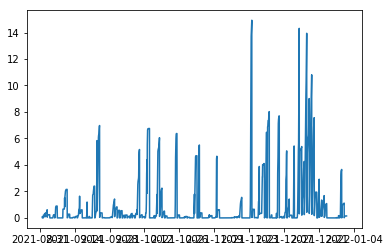

In [4]:
def interpolation(lat,long,lats,longs,zs):
    ds = []
    p  = []
    for i in range(len(lats)):
        for j in range(len(longs)):
            ds.append(np.sqrt((lat-lats[i])**2 + (long-longs[j])**2))
            p.append(1/ds[-1]**2)
    w = []
    for i in range(len(p)):
        w.append(p[i]/sum(p))
    z = 0
    for i in range(len(zs)):
        z += zs[i]*w[i]
    return z

tp = []

for i in range(len(date)):
    tp.append(interpolation(41.104, 29.019,f1.variables["latitude"][:],f1.variables["longitude"][:],list(chain.from_iterable(f1.variables["tp"][i,:,:])))*1000)
print(date[0],date[-1])
plt.plot(date,tp)
print(date[0],date[-1])
print(tp[-10:])

In [6]:
tro_xlsx = pd.read_excel("data/tro/tro.xlsx")
meteo_xlsx = pd.read_excel("data/meteo/meteo_RNX.xlsx")

(2952, 2952)


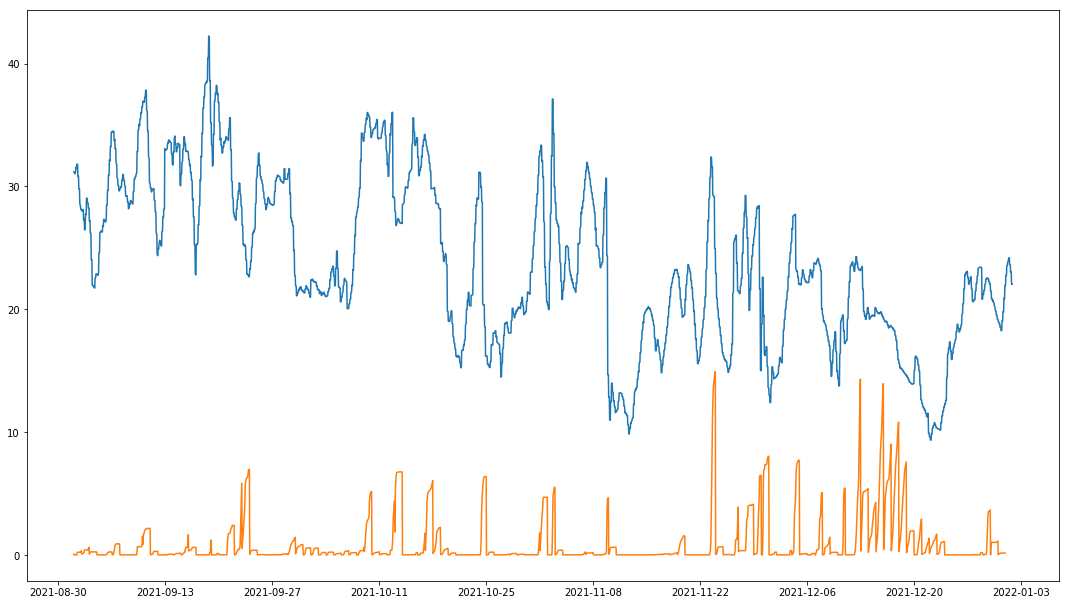

In [7]:
K2 = 16.48		#atmospheric refractivity constant (K / mbar)
K3 = 3.776*10**5	#atmospheric refractivity constant (K^2 / mbar)
pw = 103		#the density of liquid water (kg/m^3)
Rw = 461.5	#the specific gas constant for water vapor (J/(kg . K)) [J = kg * m^2 / s^2]
Ts = 288.15	#seosanal mean temperature (unit: K)
pwv = []
print(len(tro_xlsx["date"]),len(meteo_xlsx["date"]))
for i in range(len(tro_xlsx["date"])):
    Tm = 44.05 + 0.81 * (meteo_xlsx["WetT"][i]+273.15)
    pi = 10e6 / (pw * Rw * (K2 + K3 / Tm))
    pwv.append(pi * tro_xlsx["trowet"][i])
    
plt.gcf().set_size_inches(18.5, 10.5)
plt.plot(tro_xlsx["date"],pwv)
plt.plot(date,tp)
plt.savefig("deneme_ysa.jpeg",bbox_inches = 'tight', dpi=300, pad_inches = 0.02)

In [9]:
press = meteo_xlsx["press."]
dryt =  meteo_xlsx["DryT"]
hum =  meteo_xlsx["Hum."]
Temps = [i for i in range(len(hum))]
meteo_xlsx["Temps"] = Temps

In [10]:
import matplotlib.dates as md
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from mpl_toolkits.mplot3d import Axes3D
from pyneurgen.recurrent import NARXRecurrent
from pyneurgen.neuralnet import NeuralNet
from pyneurgen.nodes import BiasNode, Connection

/home/bilal/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
our1 = meteo_xlsx
our2 = pd.DataFrame(list(zip(Temps,pwv,tp)),columns =['Temps','pwv', 'tp'])
df = pd.merge(our1, our2, on='Temps')
len_df = len(df)

inpt = df[["Temps","press.","DryT","Hum.","pwv","tp"]]
output = df[["tp"]]

sc = StandardScaler()
in1 = sc.fit_transform(inpt[0:int(len_df * 0.6)]) #train and fit train input data
in2 = sc.transform(inpt[int(len_df * .6)+1:len_df-1]) #test transform 
inp = np.concatenate([in1,in2]) #add to the end df1 arr df2
inpt = pd.DataFrame(inp, columns=inpt.columns)

out1 = sc.fit_transform(output[0:int(len_df * .6)]) #train and fit train out data
out2 = sc.transform(output[int(len_df * .6)+1:len_df-1]) #test transform 
out = np.concatenate([out1,out2]) #add to the end df1 arr df2
output = pd.DataFrame(out, columns=output.columns)

In [12]:
all_inputs = inpt.values
all_targets = output.values
for val in all_targets:
    val = [val]
type(all_targets)

numpy.ndarray

In [118]:
input_nodes = 10
hidden_nodes = 10
output_nodes = 1

output_order = 6 #9
incoming_weight_from_output = .5
input_order = 6 #2
incoming_weight_from_input = .5 
net = NeuralNet()

net.init_layers(input_nodes, [hidden_nodes], output_nodes,
        NARXRecurrent(
            output_order,
            incoming_weight_from_output,
            input_order,
            incoming_weight_from_input))

net.randomize_network()

In [119]:
net.set_halt_on_extremes(True)#This function sets the flag as to whether 
#the program should halt when experiencing extremely positive or negative numbers. 
#This can happen when using linear functions and data that may not be normalized.

#   Set to constrain beginning weights to -.5 to .5
net.set_random_constraint(.5)
net.set_learnrate(.1)#This function sets the learn rate for the modeling. 
#It is used to determine how much weight to associate with an error when learning.

#the inputs and targets are loaded into the system
net.set_all_inputs(all_inputs)
net.set_all_targets(all_targets)

length = len(all_inputs)
learn_end_point = int(length * .6)#The first 70% of the data will be used for learning
validation_end_point = int(length * .7)

net.set_learn_range(0, learn_end_point)#This function sets the range within the data that is to used for learning.
net.set_validation_range(learn_end_point + 1, validation_end_point)
net.set_test_range(validation_end_point + 1, length - 1)

net.layers[1].set_activation_type('sigmoid')#sigmoid,linear TF

net.learn(epochs=6, show_epoch_results=True, random_testing=True)


epoch: 0 MSE: 0.05959724095971716
epoch: 1 MSE: 0.009106677216701971
epoch: 2 MSE: 0.005650578332679461
epoch: 3 MSE: 0.00484416920268584
epoch: 4 MSE: 0.004229196341077438
epoch: 5 MSE: 0.0032991339331983473


In [120]:
mse = net.test()#With learning complete, it is time to test and evaluate the results.
print(net.validate())
print ("mse = ", mse)
#test_positions = [item[0][1] for item in net.get_test_data()]
test_positions = [item[0][0] for item in net.get_test_data()] 
all_targets1 = [item[0][0] for item in net.test_targets_activations]
allactuals = [item[1][0] for item in net.test_targets_activations]
#test_positions
#all_targets1
learning_data = [item[1][0] for item in net.get_learn_data()]
validation_data = [item[1][0] for item in net.validation_targets_activations]
print(len(learning_data))
print(len(validation_data))
print(len(allactuals))
print((length))

0.3761639125711656
('mse = ', 0.1277823646583703)
1755
292
876
2926


[0.14641716 0.14643814 0.14643814 0.14667527 0.14711561 0.14753619
 0.14753619 0.14753619 0.14757428 0.1478429 ]
[0.08870166 0.10460049 0.08018022 0.06745604 0.07040016 0.07002163
 0.0513     0.04238097 0.04440127 0.03232537]


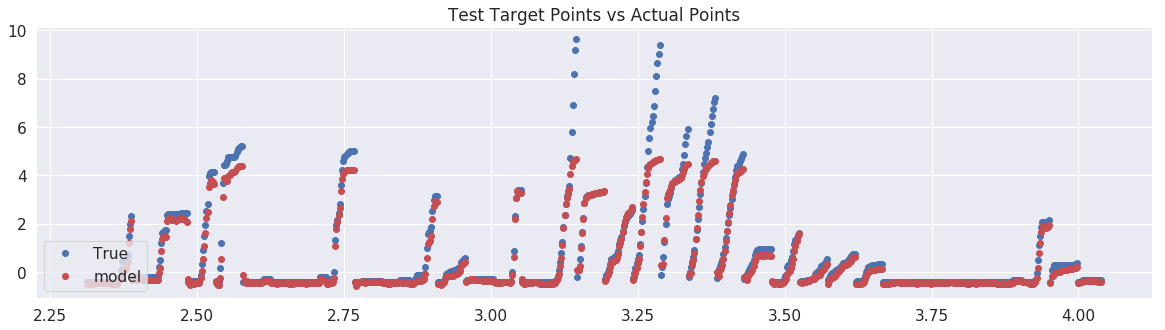

In [121]:
from pylab import plot, legend, subplot, grid, xlabel, ylabel, show, title
#subplot(3, 1, 2)
plot(test_positions, all_targets1, 'bo', label='True')
plot(test_positions, allactuals, 'ro', label='model')
grid(True)
legend(loc='lower left', numpoints=1)
title("Test Target Points vs Actual Points")
print(sc.inverse_transform(all_targets1)[-10:])
print(sc.inverse_transform(allactuals)[-10:])

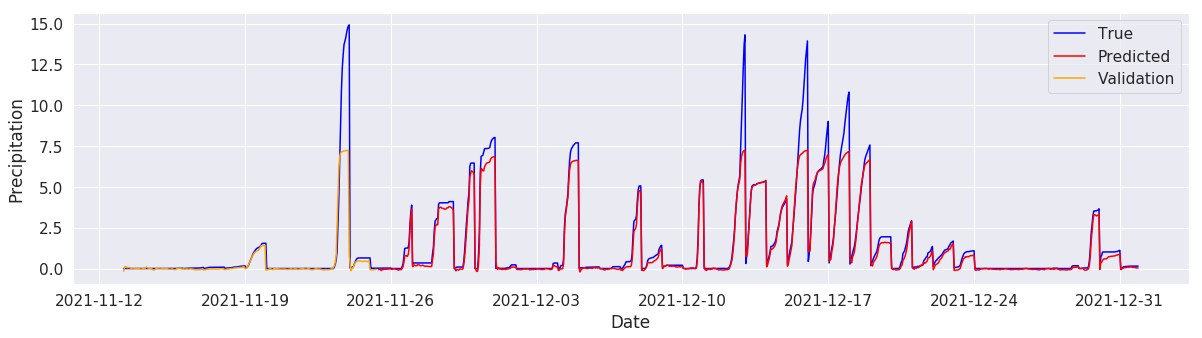

In [122]:

#our1_ = pd.read_excel("dataset.xlsx")
#our2_ = pd.read_excel("meteo.xlsx")
#df_ = pd.merge(our1, our2, on='Temps')
y_true= sc.inverse_transform(all_targets1)
y_new_inverse = sc.inverse_transform(allactuals)
learning_data_tr = sc.inverse_transform(learning_data)
validation_data_tr = sc.inverse_transform(validation_data)
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
plt.plot(date[int((len(date)) * .6):len(date)-2], tp[int((len(date)) * .6):len(date)-2],color='blue',label = "True")
#plt.plot(date[int((len(date)) * .7)+1:len(date)-2],tp[int((len(date)) * .7)+1:len(date)-2],color='red',label = "True")
plt.plot(date[int((len(date)) * .7)+1:len(date)-2], y_new_inverse, color='red',label = "Predicted")
plt.plot(date[int((len(date)) * .6):int((len(date)) * .7)-1], validation_data_tr,color='orange',label = "Validation")
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend()
#plt.plot(df_.Time[learn_end_point + 1:length - 1], df_.Global_reactive_power[learn_end_point + 1:length - 1])
#plt.plot(df_.Time[learn_end_point + 1:length - 1], y_new_inverse, color='red')
#plt.plot(df_graph.Time[learn_end_point + 1:learn_end_point+3], df_graph.Internaltemp[learn_end_point + 1:learn_end_point+3])
#plt.plot(df_graph.Time[learn_end_point + 1:learn_end_point+3], y_new_inverse[0:2], color='red')
plt.savefig("ysa_graph.jpeg")
#len(y_new_inverse)

In [123]:
print((np.power(np.array(tp[int((len(date)) * .6):int((len(date)) * .7)-1]) - np.array(validation_data_tr), 2).mean()))
print((np.power(np.array(tp[int((len(date)) * .7)+1:len(date)-2]) - np.array(y_new_inverse), 2).mean()))

2.021926199915304
0.5144691459216616


In [124]:
no_rain = 0
modarate_rain= 0
intense_rain = 0
predicted_class = []
for i in y_new_inverse:
    if int(i) == 0:
        no_rain += 1
        predicted_class.append("no_rain")
    elif i <= 5:
        modarate_rain += 1
        predicted_class.append("modarate_rain")
    if i > 5:
        intense_rain += 1
        predicted_class.append("intense_rain")
print(no_rain)
print(modarate_rain)
print(intense_rain)

602
153
121


In [125]:
no_rain = 0
modarate_rain= 0
intense_rain = 0
true_class = []
for i in y_true:
    if int(i) == 0:
        no_rain += 1
        true_class.append("no_rain")
    elif i <= 5:
        modarate_rain += 1
        true_class.append("modarate_rain")
    if i > 5:
        intense_rain += 1
        true_class.append("intense_rain")
print(no_rain)
print(modarate_rain)
print(intense_rain)

549
203
124


In [126]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(true_class, predicted_class, labels=["no_rain", "modarate_rain", "intense_rain"])
report = metrics.classification_report(true_class, predicted_class, labels=["no_rain", "modarate_rain", "intense_rain"])
print(confusion_matrix)
print(report)


[[547   2   0]
 [ 55 146   2]
 [  0   5 119]]
               precision    recall  f1-score   support

      no_rain       0.91      1.00      0.95       549
modarate_rain       0.95      0.72      0.82       203
 intense_rain       0.98      0.96      0.97       124

  avg / total       0.93      0.93      0.92       876



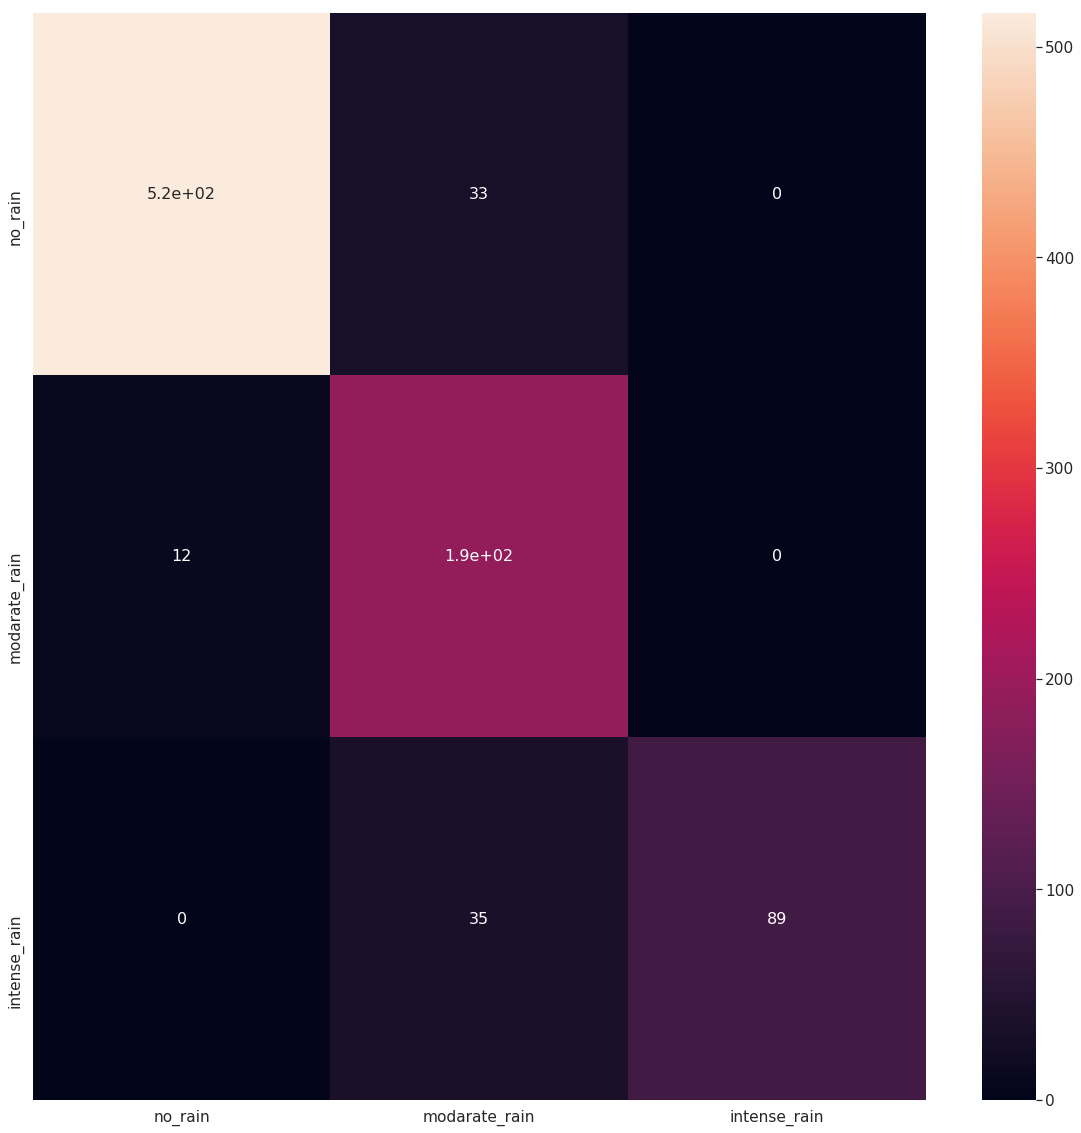

In [85]:
import seaborn as sn

df_cm = pd.DataFrame(confusion_matrix, index = ["no_rain", "modarate_rain", "intense_rain"],
                  columns = ["no_rain", "modarate_rain", "intense_rain"])
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})